In [1]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from pdb import set_trace as breakpoint
from time import time

from neural_maxwell.datasets.fdfd import Simulation2D
from neural_maxwell.datasets.generators import PermittivityGenerators2D 
from neural_maxwell.datasets.datasets import PermittivityDataset
from neural_maxwell.models.maxwell_2d import MaxwellSolver2D
from neural_maxwell.constants import *
from neural_maxwell.utils import pbar
from neural_maxwell.plotting import plot_model_outputs_2d

## Training

In [5]:
# Hyperparameters
num_epochs = 2000
learning_rate = 5e-6
batch_size = 512

# Create a model   
channels = [64] * 7
kernels = [5] * 7
# model = MaxwellSolver2D(buffer_length=0, buffer_permittivity=1.0, npml = 4, channels=channels, kernels=kernels, drop_p=0.0, add_buffer=False).to(device)
model = MaxwellSolver2D(src_y=16, src_x=3, buffer_length=4, channels=channels, kernels=kernels, drop_p=0.0).to(device)


# Create data loaders
train_data = PermittivityDataset(PermittivityGenerators2D.ellipse, N=1, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = PermittivityDataset(PermittivityGenerators2D.ellipse, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001) 

In [6]:
# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = False
    if SHOW_ITERATION_PROGRESS:
        train_iterator = pbar(train_loader)
    else:
        train_iterator = train_loader
        
    for i, epsilons in enumerate(train_iterator):
        
        epsilons = epsilons.float().to(device)

        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), '../models/checkpoints/model2d_complex.ckpt')

In [7]:
# data_0 = torch.tensor([train_data[0].numpy()], device=device).float()
# data_0 = F.pad(data_0, [model.npml + model.buffer_length] * 4, "constant", model.buffer_permittivity)
# model.get_fields(data_0)

In [4]:
# Compute loss on test set

model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
test_losses = []

with torch.no_grad():
    start = time()
    for epsilons in pbar(test_loader):
        epsilons = epsilons.float().to(device)
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        test_losses.append(loss.item())

print(f"Mean loss: {np.mean(np.array(test_losses))}, time: {time()-start}")


Mean loss: 0.0010674395383102819, time: 3.6103878021240234


Sim time: 0.01859 | Network time: 0.00280 | Ratio: 0.15089


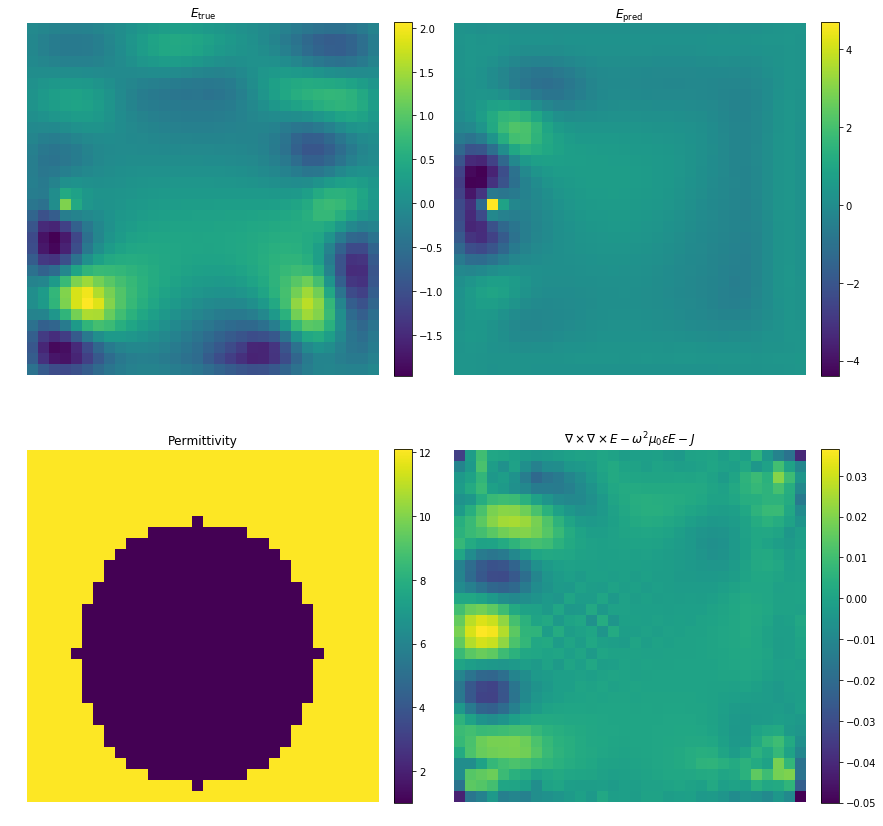

In [8]:
model.eval()
epsilons = train_data[0].numpy()
plot_model_outputs_2d(model, epsilons, rescale=True)

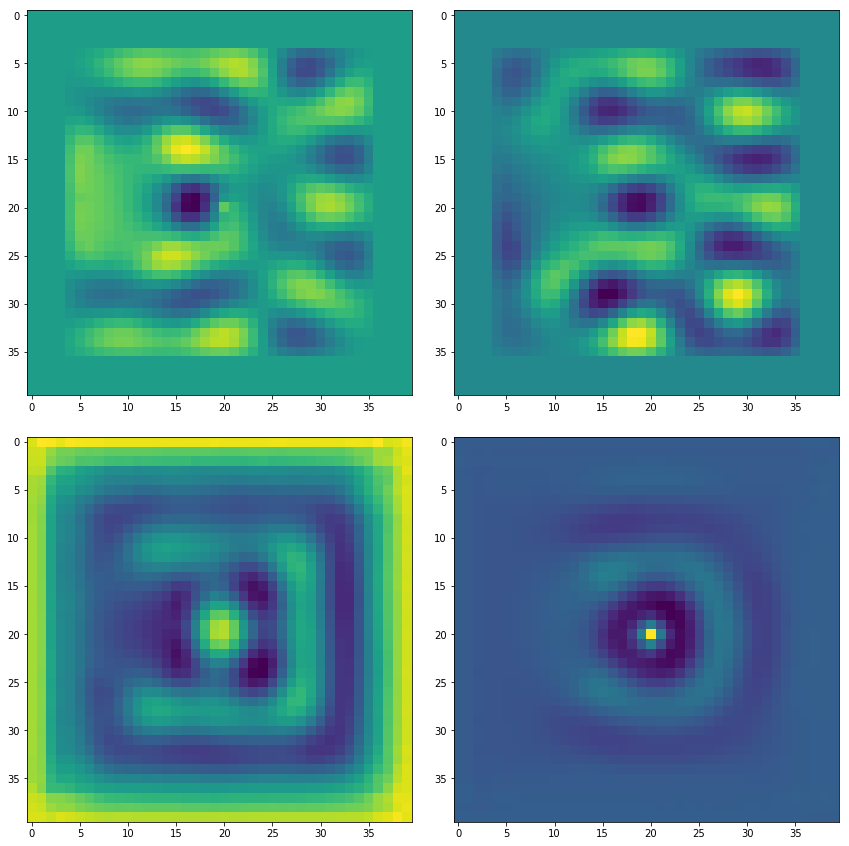

In [13]:
model.eval()
epsilons = train_data[0].numpy()


f, ax = plt.subplots(2, 2, figsize=(12,12))
f.tight_layout()

ul, ur = ax[0]
ll, lr = ax[1]
    
_, _, _, _, _, Ez_true = Simulation2D(device_length=model.size, buffer_length=model.buffer_length, npml=model.npml).solve(epsilons, src_x=model.src_x, src_y=model.src_y)

data_0 = torch.tensor([train_data[0].numpy()], device=device).float()
data_0 = F.pad(data_0, [model.npml + model.buffer_length] * 4, "constant", model.buffer_permittivity)
E_re, E_im = model.get_fields(data_0)
E_re = E_re.cpu().detach().numpy()[0]
E_im = E_im.cpu().detach().numpy()[0]

ul.imshow(np.real(Ez_true))
ur.imshow(np.imag(Ez_true))

ll.imshow(E_re)
lr.imshow(E_im)

#epsilons = PermittivityGenerators2D.ellipse()
# plot_model_outputs_2d(model, epsilons, rescale=True)